## Cart Pole with REINFORCE (assignment verion)
### Christian Igel, 2023

If you have suggestions for improvements, [let me know](mailto:igel@diku.dk).

Imports:

In [1]:
import gymnasium as gym

from tqdm.notebook import tqdm, trange  # Progress bar
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

We need [the `gymnasium` package](https://gymnasium.farama.org/).
From this package, we create the Cart-Pole game environment:

In [2]:
env = gym.make('CartPole-v1')
action_size = 2
state_size = 4

Let's just test the environment first:

In [3]:
test_episodes = 10
for _ in range(test_episodes):
    R = 0
    state = env.reset()  # Environment starts in a random state, cart and pole are moving
    print("initial state:", state)
    while True:  # Environment sets "truncated" to true after 500 steps 
        # Uncomment the line below to watch the simulation
        env.render()
        state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) #  Take a random action
        R += reward  # Accumulate reward
        if terminated or truncated:
            print("return: ", R)
            env.reset()
            break

initial state: (array([-0.04155499, -0.02763035,  0.04956355, -0.03302893], dtype=float32), {})
return:  32.0
initial state: (array([-0.02904478,  0.03755196, -0.0362227 ,  0.03132551], dtype=float32), {})
return:  23.0
initial state: (array([-0.02392958,  0.02836937,  0.01476433, -0.0478358 ], dtype=float32), {})
return:  30.0
initial state: (array([-0.01645464, -0.00729021, -0.00089248,  0.00889087], dtype=float32), {})
return:  36.0
initial state: (array([-0.03106456, -0.00804045,  0.02524931, -0.017769  ], dtype=float32), {})
return:  18.0
initial state: (array([-0.03581848,  0.01034657, -0.0133271 ,  0.03403145], dtype=float32), {})
return:  11.0
initial state: (array([-0.01978251,  0.01235992, -0.0276988 ,  0.00933812], dtype=float32), {})
return:  9.0
initial state: (array([-0.00234293, -0.04953203, -0.00065173,  0.01567808], dtype=float32), {})
return:  25.0
initial state: (array([ 0.00509356, -0.0143148 , -0.00412494,  0.03192516], dtype=float32), {})
return:  29.0
initial sta

/home/tokereines/.cache/pypoetry/virtualenvs/10-orel-EypsHRW3-py3.10/lib/python3.10/site-packages/gymnasium/envs/classic_control/cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [4]:
env.close()  # Closes the visualization window

After 500 steps an episode is truncated.

## REINFORCE

Let's define a policy class for a simple softmax policy for real-valued feature vectors and discrete actions.

In [5]:
class Softmax_policy:
    def __init__(self, no_actions, no_features):
        """
        Initialize softmax policy for discrete actions
        :param no_actions: number of actions
        :param no_features: dimensionality of feature vector representing a state
        """        
        self.no_actions = no_actions
        self.no_features = no_features

        # Initialize policy parameters to zero
        self.theta = np.zeros([no_actions, no_features])
        
    def pi(self, s):
        """
        Compute action probabilities in a given state
        :param s: state feature vector
        :return: an array of action probabilities
        """
        # Compute action preferences for the given feature vector
        preferences = self.theta.dot(s)
        # Convert overflows to underflows
        preferences = preferences - preferences.max()
        # Convert the preferences into probabilities
        exp_prefs = np.exp(preferences)
        return exp_prefs / np.sum(exp_prefs)
    
    def inc(self, delta):
        """
        Change the parameters by addition, e.g. for initialization or parameter updates 
        :param delta: values to be added to parameters
        """
        self.theta += delta

    def sample_action(self, s):
        """
        Sample an action in a given state
        :param s: state feature vector
        :return: action
        """
        return np.random.choice(self.no_actions, p=self.pi(s))
    
    def gradient_log_pi(self, s, a):
        """
        Computes the gradient of the logarithm of the policy
        :param s: state feature vector
        :param a: action
        :return: gradient of the logarithm of the policy
        """
        # Compute action probabilities for all actions
        pi_s = self.pi(s)
        
        # Initialize gradient matrix
        d = np.zeros(self.theta.shape)
        
        # Compute gradient for all actions and features
        for action in range(self.no_actions):
            d[action, :] = s * (int(action == a) - pi_s[action]) 
        
        return d

    def gradient_log_pi_test(self, s, a, eps=0.1):
        """
        Numerically approximates the gradient of the logarithm of the policy
        :param s: state feature vector
        :param a: action
        :return: approximate gradient of the logarithm of the policy
        """
        theta_correct = np.copy(self.theta)
        log_pi = np.log(self.pi(s)[a])
        d = np.zeros([self.no_actions, self.no_features])
        for i in range(self.no_actions):
            for j in range(self.no_features):
                self.theta[i,j] += eps
                log_pi_eps = np.log(self.pi(s)[a])
                d[i,j] = (log_pi_eps - log_pi) / eps
                self.theta = np.copy(theta_correct)
        return d
  
    
    

Verify gradient implementation:

In [6]:
s = env.reset()[0]
pi = Softmax_policy(action_size, state_size)
tolerance = 0.0001  # Absolute tolerance for difference in each gradient component
for _ in range(10):
    pi.inc(10.*np.random.rand(action_size, state_size))
    if not np.isclose(pi.gradient_log_pi(s, 0), pi.gradient_log_pi_test(s, 0), atol=tolerance).all():
        print("derivative test for action 0:")
        print(pi.gradient_log_pi(s, 0))
        print(pi.gradient_log_pi_test(s, 0))
        print("derivative test for action 1")
        print(pi.gradient_log_pi(s, 1))
        print(pi.gradient_log_pi_test(s, 1))

Do the learning:

In [7]:
alpha = 0.001  # Learning rate
no_episodes = 1000  # Number of episodes
total_reward_list = []  # Returns for the individual episodes
pi = Softmax_policy(action_size, state_size)  # Policy

# Do the learning
for e in trange(no_episodes):  #  Loop over episodes
    R = []  # Store rewards r_1, ..., r_T
    S = []  # Store actions a_0, ..., a_{T-1}
    A = []  # Store states s_0, ..., s_{T-1}
    state = env.reset()[0]  # Environment starts in a random state, cart and pole are moving
    while True:  # Environment sets "done" to true after 200 steps 
        S.append(state)
        
        action = pi.sample_action(state)  # Take an action following pi
        A.append(action)
        
        state, reward, terminated, truncated, _ = env.step(action)  # Observe reward and new state
        R.append(reward)
                
        if terminated or truncated:  # Failed or succeeded?
            break
            
    R = np.array(R)
    total_reward_list.append((e, R.sum()))
    
    for t in range(R.size):
        R_t = R[t:].sum()  # Accumulated future reward
        Delta = alpha * R_t * pi.gradient_log_pi(S[t], A[t])  # REINFORCE update
        pi.inc(Delta)  # Apply update
    

  0%|          | 0/1000 [00:00<?, ?it/s]

Plot learning process:

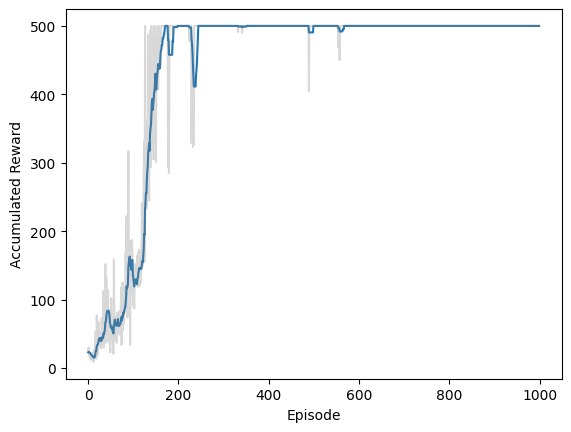

In [8]:
# Moving average for smoothing plot
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, x[0]*np.ones(N)))
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(total_reward_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps, smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward');

In [9]:
# Verification of the gradient implementation
policy = Softmax_policy(action_size, state_size)
s = np.random.rand(state_size)  # Example feature vector
a = np.random.randint(action_size)  # Example action

# Compute analytical and numerical gradients
analytical_grad = policy.gradient_log_pi(s, a)
numerical_grad = policy.gradient_log_pi_test(s, a)

print("Analytical gradient:", analytical_grad)
print("Numerical gradient:", numerical_grad)
print("Difference:", analytical_grad - numerical_grad)
# Compare the gradients
assert np.allclose(analytical_grad, numerical_grad, atol=1e-1), "Gradients do not match."


Analytical gradient: [[ 0.38104772  0.4314595   0.16207954  0.22280903]
 [-0.38104772 -0.4314595  -0.16207954 -0.22280903]]
Numerical gradient: [[ 0.37378961  0.42215452  0.16076611  0.22032704]
 [-0.38830583 -0.44076448 -0.16339297 -0.22529101]]
Difference: [[0.00725811 0.00930498 0.00131343 0.00248199]
 [0.00725811 0.00930498 0.00131343 0.00248199]]
